<p style="font-size:24pt;font-weight:bold">Classification of Seizure EEG with Convolutional Neural Network</p>

# Objective

In this project, I ask the following question: can deep neural network distinguish between EEG activities before seizure, during seizure and healthy conditions? Being able to identify periods before seizure onset may be especially important for treamtment in seizure-prone patients and healthcare practitioner.

Here, I use deep convolutional neural network to classify spectrograms of 19-channel EEG recordings. 

# Overview

* [Explore Temple Hospital Seizure EEG dataset](#Explore-Temple-Hospital-Seizure-EEG-dataset): in which I perform basic analysis of EEG data to gain understanding of the Temple Hospital Seizure EEG dataset

* [Explore Excel Label File](#Explore-Excel-label-file): in which I examined the distributions of type of data available, preparing for later training of deep convolutional neural network (data slicing, data balancing, etc).

* [Classification of seizure vs. non-seizure EEG using a 2D convolutional neural network (2D)](#classify): here I used a simple deep convolutional neural network structure to classify specotrogram images of the EEG data (non-seizure, background, and seizure), and obtained a final accuracy about 83% on the validation and test set.

# Explore Temple Hospital Seizure EEG dataset

Previously, I attempted to load the data with pyedflib, but was unsuccessful. I reimplemented a file parser using Python based on the byte by byte explanation of the .edf file found on their website. Seems to be working pretty well. In the present notebook, I will perform some preliminary analysis of the EEG data, using my previous knowledge, in order to gain some preliminary understanding of the dataset.

In [1]:
%run '/Users/edward/Documents/Scripts/Python/init_py.py'  #macosx
addpythonpkg('ReadNWrite')
addpythonpkg('generic')
from MATLAB import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal, stats
from IPython import display
import seaborn as sns
import warnings
import json
from edf import * # custom parser

jupyter mode


## List all the files

In [7]:
basedir = '/Volumes/Storage/TUH_EEG/'
P_train, N_train = SearchFiles(os.path.join(basedir, 'train'), '*/*/*/*/*.edf')
P_test, N_test = SearchFiles(os.path.join(basedir, 'dev_test'), '*/*/*/*/*.edf')
P = P_train + P_test
N = N_train + N_test
print('train:', len(N_train))
print('test:', len(N_test))

train: 1984
test: 1013


## Double check if all the record duration is 1.0 second
This way, we can simply use `.num_records` for duration of the sample.

In [7]:
l = len(P)
printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
for n, p in enumerate(P):
    printProgressBar(n+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    eeg_data = EDF(p, header_only=True)
    if abs(eeg_data.header.duration - 1.0)>1E-6:
        print(p)
        
print('Finished Checking')

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Finished Checking


**Conclusion**: All duration is 1.0 second. We can use `.num_records` for duration of the sample

## Calculate the average durations and # channels of the samples

In [173]:
def duration_x_channel(P):
    l = len(P)
    eeg_durations, eeg_channels = np.zeros(l), np.zeros(l)
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for n, p in enumerate(P):
        printProgressBar(n+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        eeg_data = EDF(p, header_only=True)
        eeg_durations[n] = eeg_data.header.num_records
        eeg_channels[n] = eeg_data.header.num_signals

    print('Durations: ', np.mean(eeg_durations), '±', np.std(eeg_durations))
    print('min: ', np.min(eeg_durations), 'max: ', np.max(eeg_durations))
    print(eeg_durations)

    print('# channels: ', np.mean(eeg_channels), '±', np.std(eeg_channels))
    print('min: ', np.min(eeg_channels), 'max: ', np.max(eeg_channels))
    print(eeg_channels)
    return eeg_durations, eeg_channels


In [176]:
print('all')
eeg_durations, eeg_channels = duration_x_channel(P)

all
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Durations:  600.6252919586253 ± 449.9848120385344
min:  16.0 max:  3526.0
[1205. 1442. 1197. ...  425.  365.  395.]
# channels:  32.46813480146813 ± 3.5574416390896606
min:  25.0 max:  41.0
[36. 36. 36. ... 32. 32. 32.]


In [175]:
print('train')
eeg_durations_train, eeg_channels_train = duration_x_channel(P_train)

train
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Durations:  598.2066532258065 ± 456.4903538756773
min:  16.0 max:  3526.0
[1205. 1442. 1197. ...  375.  373.   55.]
# channels:  32.65625 ± 3.768607229949684
min:  25.0 max:  41.0
[36. 36. 36. ... 32. 32. 32.]


In [177]:
print('test')
eeg_durations_test, eeg_channels_test = duration_x_channel(P_test)

test
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Durations:  605.3622902270483 ± 436.9241476493356
min:  17.0 max:  3405.0
[ 20. 272. 234. ... 425. 365. 395.]
# channels:  32.09970384995064 ± 3.0692774199648047
min:  27.0 max:  41.0
[32. 32. 32. ... 32. 32. 32.]


## Data structure explore

In [3]:
eeg_data = EDF(P_train[0])
print('Length (s):', eeg_data.header.num_records)
print('# Channels: ', eeg_data.header.num_signals)
print('Sampling rate (points per sec): ', eeg_data.header.sample_rate)

Length (s): 1205
# Channels:  36
Sampling rate (points per sec):  [250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 1, 1, 1]


## Do some plots

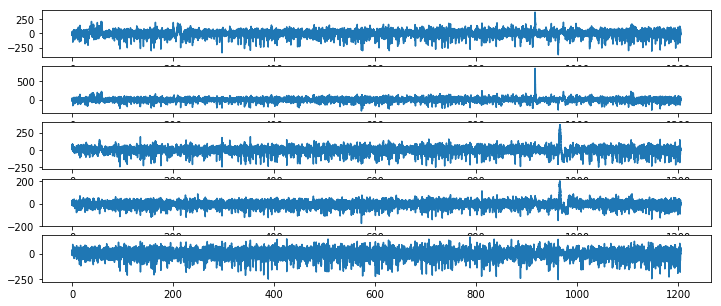

In [8]:
eeg_data = EDF(P_train[0])
fig, axs = plt.subplots(5, 1)
fig.set_size_inches(12, 5)
for n, ax in enumerate(axs):
    time_base = np.arange(0, eeg_data.header.num_records, 1/eeg_data.header.sample_rate[n])
    ax.plot(time_base, eeg_data.data[n])

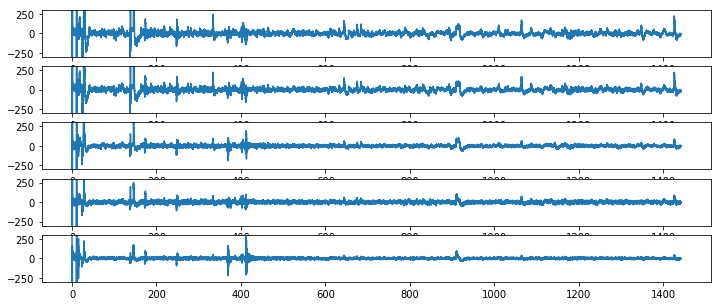

In [10]:
eeg_data = EDF(P_train[1])
fig, axs = plt.subplots(5, 1)
fig.set_size_inches(12, 5)
for n, ax in enumerate(axs):
    time_base = np.arange(0, eeg_data.header.num_records, 1/eeg_data.header.sample_rate[n])
    ax.plot(time_base, eeg_data.data[n])
    ax.set_ylim(-300, 300)

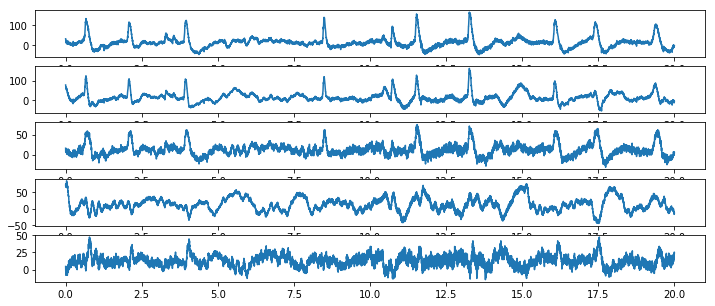

In [11]:
eeg_data = EDF(P_test[0])
fig, axs = plt.subplots(5, 1)
fig.set_size_inches(12, 5)
for n, ax in enumerate(axs):
    time_base = np.arange(0, eeg_data.header.num_records, 1/eeg_data.header.sample_rate[n])
    ax.plot(time_base, eeg_data.data[n])

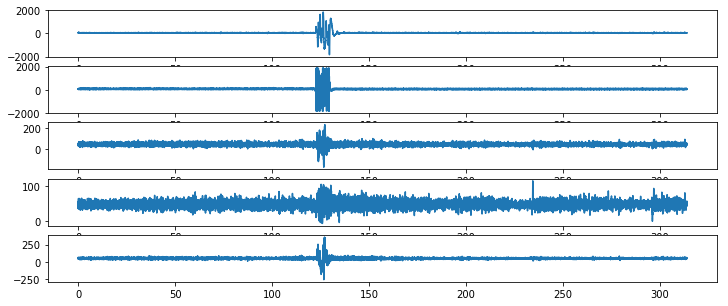

In [12]:
eeg_data = EDF(P_train[50])
fig, axs = plt.subplots(5, 1)
fig.set_size_inches(12, 5)
for n, ax in enumerate(axs):
    time_base = np.arange(0, eeg_data.header.num_records, 1/eeg_data.header.sample_rate[n])
    ax.plot(time_base, eeg_data.data[n])

## Finding common channels across the dataset
At least for the first pass of analysis, do not deal with missing data / channel

In [15]:
def find_common_channels(P):
    eeg_data = EDF(P[0], header_only=True)
    available_channels = [ll.replace("EEG ","").replace("-REF","").replace("-LE","") \
                          for ll in eeg_data.header.labels]

    l = len(P)
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for n, p in enumerate(P):
        printProgressBar(n+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        eeg_data = EDF(p, header_only=True)
        labels = [ll.replace("EEG ","").replace("-REF","").replace("-LE","") \
                          for ll in eeg_data.header.labels]
        available_channels = list(set(available_channels) & set(labels))
        
    print(len(available_channels), 'channels')
    print(available_channels)

In [18]:
find_common_channels(P)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
19 channels
['T4', 'O1', 'F8', 'FZ', 'P4', 'F4', 'F3', 'FP2', 'O2', 'T6', 'CZ', 'PZ', 'F7', 'C3', 'P3', 'T5', 'C4', 'T3', 'FP1']


In [19]:
find_common_channels(P_train)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
19 channels
['T4', 'O1', 'F8', 'FZ', 'P4', 'F4', 'F3', 'FP2', 'O2', 'T6', 'CZ', 'PZ', 'F7', 'C3', 'P3', 'T5', 'C4', 'T3', 'FP1']


In [20]:
find_common_channels(P_test)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
19 channels
['T4', 'O1', 'F8', 'FZ', 'P4', 'F4', 'F3', 'FP2', 'O2', 'T6', 'CZ', 'PZ', 'F7', 'C3', 'P3', 'T5', 'C4', 'T3', 'FP1']


**Conclusion**: should only use the following 19 channels

In [4]:
channels = ['T4', 'O1', 'F8', 'FZ', 'P4', 'F4', 'F3', 'FP2', 'O2', 'T6', 'CZ', 'PZ', 'F7', 'C3', 'P3', 
            'T5', 'C4', 'T3', 'FP1']

## Find out the sample rates for the data

In [24]:
def find_sample_rate(P, channels):
    sample_rates = [[]] * len(P)
    unique_rates = [[]] * len(P)

    l = len(P)
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for n, p in enumerate(P):
        printProgressBar(n+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        eeg_data = EDF(p, header_only=True)
        labels = [ll.replace("EEG ","").replace("-REF","").replace("-LE","") \
                          for ll in eeg_data.header.labels]
        current_sample_rates = [eeg_data.header.sample_rate[labels.index(c)] for c in channels]
        unique_rates[n] = len(set(current_sample_rates)) > 1
        sample_rates[n] = current_sample_rates[0]
    
    sample_rates_unqiue, counts = np.unique(sample_rates, return_counts=True)
    print('rates: ', np.mean(sample_rates), '±', np.std(sample_rates))
    for sru, cc in zip(sample_rates_unqiue, counts):
        print(sru, ':', cc)
    print('All has unique rates:', all(sample_rates))
                                
    return sample_rates, unique_rates

In [25]:
sample_rates, _ = find_sample_rate(P_train, channels)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
rates:  286.63004032258067 ± 66.20304349912291
250 : 605
256 : 966
400 : 369
512 : 44
All has unique rates: True


In [26]:
sample_rates, _ = find_sample_rate(P_test, channels)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
rates:  276.5310957551826 ± 60.40768266421519
250 : 139
256 : 751
400 : 88
512 : 35
All has unique rates: True


**Conclusion**: resample everything to 256 samples per second, since most of the data has that sampling rate

## Resampling example

In [80]:
eeg_data = EDF(P_train[4])
wdata = eeg_data.data[0]
wdata.shape

(77600,)

In [81]:
warnings.filterwarnings("ignore")
time_base = np.arange(0, eeg_data.header.num_records, 1/eeg_data.header.sample_rate[0])
wdata2, time_base2 = signal.resample(wdata, eeg_data.header.num_records * 256, time_base)

In [92]:
print(len(wdata))
print(len(wdata2))

77600
49664


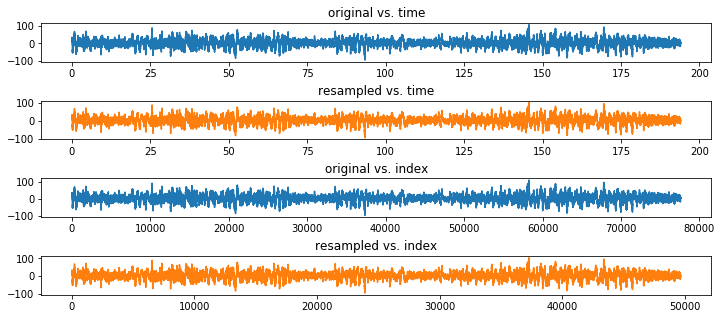

In [90]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(4,1,1)
plt.plot(time_base, wdata)
plt.title('original vs. time')
plt.subplot(4,1,2)
plt.plot(time_base2, wdata2, color=tableau10[1])
plt.title('resampled vs. time')
plt.subplot(4, 1,3)
plt.plot(wdata)
plt.title('original vs. index')
plt.subplot(4, 1,4)
plt.plot(wdata2, color=tableau10[1])
plt.title('resampled vs. index')
plt.subplots_adjust(hspace=1)

## Converting each of the avaiable channels into a spectrogram

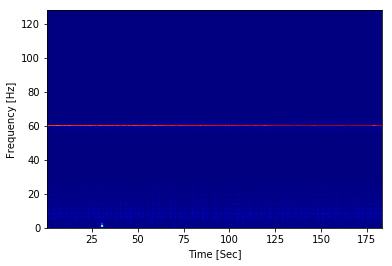

In [13]:
eeg_data = EDF(P_train[13])    
c = channels[0]
labels = [ll.replace("EEG ", "").replace("-LE", "").replace("-REF","") for ll in eeg_data.header.labels]
index = labels.index(c)
wdata = eeg_data.data[index]
wdata = signal.resample(wdata, eeg_data.header.num_records * 256)
fs = 256
frequencies, times, spectrogram = signal.spectrogram(wdata, fs)
plt.pcolormesh(times, frequencies, spectrogram, cmap='jet')
plt.xlabel('Time [Sec]')
_ = plt.ylabel('Frequency [Hz]')

**Conclusion**: strong 60Hz artifacts. Need to turn on the notch filter

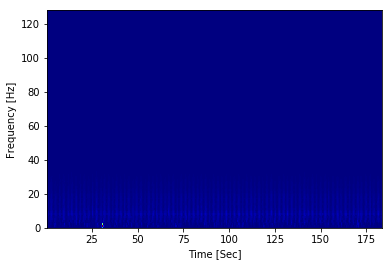

In [14]:
def EEG2Spectrogram(eeg_data, channels=None, sample_rate=256, window='hann', T=1, ts=0.5):
    """
    eeg_data
    channels: list of subset of channels 
    sample_rate: samples per second.
    window: window type. Default 'hann'
    T: window size (sec). Default 1 second
    ts: time resolution (sec). Deafult 0.5 second
    """
    warnings.filterwarnings("ignore")
    if channels is None:
        channels = eeg_data.header.labels
    
    
    labels = [ll.replace("EEG ", "").replace("-LE", "").replace("-REF","") for ll in eeg_data.header.labels]
    for n, c in enumerate(channels):
        index = labels.index(c)
        wdata = eeg_data.data[index]
        # resample if necessary
        if sample_rate is not None:
            wdata = signal.resample(wdata, eeg_data.header.num_records * sample_rate)
            fs = sample_rate
        else:
            fs = eeg_data.header.sample_rate[index]
            
        # Apply the notch filter to filter out 60 Hz artifacts
        b, a = signal.iirnotch(60 / (fs/2), 30)
        wdata = signal.filtfilt(b, a, wdata)

        # make spectrogram
        frequencies, times, Sxx = signal.spectrogram(wdata, fs, window=window,
                                                     nperseg=int(fs*T), noverlap=int(fs*(T-ts)))
        
        # Upon first iteration of running, initialize the spectrogram matrix
        if n == 0: 
            spectrogram = np.empty((len(channels), len(frequencies), len(times)))
        
        spectrogram[n, :, :] = Sxx
            
    return frequencies, times, spectrogram

eeg_data = EDF(P_train[13])    
frequencies, times, spectrogram = EEG2Spectrogram(eeg_data, channels=channels)
plt.pcolormesh(times, frequencies, spectrogram[0], cmap='jet')
plt.xlabel('Time [Sec]')
_ = plt.ylabel('Frequency [Hz]')

In [ ]:
# Loop and write the spectrograms into files later
for p in P:
    frequencies, times, spectrogram = EEG2Spectrogram(eeg_data, channels=channels)
    

# Explore Excel label file

In [10]:
excelsheet = './_DOCS/seizures_v31r.xlsx'
df_train = pd.read_excel(excelsheet, 'train').iloc[1:2895, :15]
df_train = df_train.rename(columns={'Seizure Time': 'Seizure Start Time', 'Unnamed: 13': 'Seizure End Time'})
df_train.columns = [c.replace("\n", "") for c in df_train.columns]
df_train['Seizure Start Time'] = df_train['Seizure Start Time'].astype(np.float64)
df_train['Seizure End Time'] = df_train['Seizure End Time'].astype(np.float64)
df_train['Seizure Duration'] = df_train['Seizure End Time'] - df_train['Seizure Start Time']
df_train.head()

,Index,File No.,Patient,Session,File,EEG Type,EEG SubType,LTM -or- Routine,Normal/Abnormal,No. Seizures/File,No. Seizures/Session,Filename,Seizure Start Time,Seizure End Time,Seizure Type,Seizure Duration
1,1,1.0,77.0,s003,t000,Outpatient,Outpatient,Routine,Abnormal,0.0,0.0,./edf/train/01_tcp_ar/000/00000077/s003_2010_0...,NaN,NaN,NaN,NaN
2,2,2.0,254.0,s005,t000,Outpatient,Outpatient,Routine,Abnormal,0.0,0.0,./edf/train/01_tcp_ar/002/00000254/s005_2010_1...,NaN,NaN,NaN,NaN
3,3,3.0,254.0,s006,t001,Outpatient,Outpatient,Routine,Abnormal,0.0,0.0,./edf/train/01_tcp_ar/002/00000254/s006_2011_0...,NaN,NaN,NaN,NaN
4,4,4.0,254.0,s007,t000,Inpatient,General,Routine,Abnormal,0.0,0.0,./edf/train/01_tcp_ar/002/00000254/s007_2013_0...,NaN,NaN,NaN,NaN
5,5,5.0,272.0,s007,t000,ICU,BURN,LTM,Abnormal,0.0,0.0,./edf/train/01_tcp_ar/002/00000272/s007_2003_0...,NaN,NaN,NaN,NaN


In [11]:
df_test = pd.read_excel(excelsheet, 'dev_test').iloc[1:1411, :15]
df_test = df_test.rename(columns={'Seizure Time':'Seizure Start Time', 'Unnamed: 13': 'Seizure End Time'})
df_test.columns = [c.replace("\n", "") for c in df_test.columns]
df_test['Seizure Start Time'] = df_test['Seizure Start Time'].astype(np.float64)
df_test['Seizure End Time'] = df_test['Seizure End Time'].astype(np.float64)
df_test['Seizure Duration'] = df_test['Seizure End Time'] - df_test['Seizure Start Time']
df_test.head()

,Index,File No.,Patient,Session,File,EEG Type,EEG SubType,LTM -or- Routine,Normal/Abnormal,No. Seizures/File,No. Seizures/Session,Filename,Seizure Start Time,Seizure End Time,Seizure Type,Seizure Duration
1,1,1.0,258.0,s002,t000,Outpatient,Outpatient,LTM,Abnormal,0.0,1.0,./edf/dev_test/01_tcp_ar/002/00000258/s002_200...,NaN,NaN,NaN,NaN
2,2,2.0,NaN,NaN,t002,NaN,NaN,NaN,NaN,1.0,NaN,./edf/dev_test/01_tcp_ar/002/00000258/s002_200...,15.9375,136.4375,TCSZ,120.5000
3,3,3.0,258.0,s003,t000,Outpatient,Outpatient,LTM,Abnormal,1.0,6.0,./edf/dev_test/01_tcp_ar/002/00000258/s003_200...,13.0225,143.3225,TCSZ,130.3000
4,4,4.0,NaN,NaN,t001,NaN,NaN,NaN,NaN,1.0,NaN,./edf/dev_test/01_tcp_ar/002/00000258/s003_200...,45.9300,162.2325,TCSZ,116.3025
5,5,5.0,NaN,NaN,t002,NaN,NaN,NaN,NaN,1.0,NaN,./edf/dev_test/01_tcp_ar/002/00000258/s003_200...,8.8275,202.0000,TCSZ,193.1725


In [48]:
# Checking if files in the excelsheet really exists in the dataset
import time
df = df_train
basedir = '/Volumes/Storage/TUH_EEG'
tse_file_exists = np.zeros(df.shape[0])
edf_file_exists = np.zeros(df.shape[0])
lbl_file_exists = np.zeros(df.shape[0])
l = int(df.shape[0])
printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
for i in df.index:
    printProgressBar(i, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    filepath = df.loc[i, 'Filename'].replace('./edf', basedir)
    tse_file_exists[i-1] = os.path.isfile(filepath)
    edf_file_exists[i-1] = os.path.isfile(filepath.replace('.tse', '.edf'))
    lbl_file_exists[i-1] = os.path.isfile(filepath.replace('.tse', '.lbl'))
    time.sleep(0.001)

print(all(tse_file_exists), ':', np.sum(tse_file_exists))
print(all(lbl_file_exists), ':', np.sum(lbl_file_exists))
print(all(edf_file_exists), ':', np.sum(edf_file_exists))

Progress: |██████████████████████████████████████████████████| 100.0% Complete
True : 2894.0
True : 2894.0
True : 2894.0


## Count how many entries correspond to each file

In [128]:
print('train (unique vs. entries):', len(df_train['Filename'].unique()), "/", df_train.shape[0])
print('test (unique vs. entries):', len(df_test['Filename'].unique()), "/", df_test.shape[0])

train (unique vs. entries): 1984 / 2894
test (unique vs. entries): 1011 / 1410


In [158]:
train_files, train_counts = np.unique(df_train['Filename'], return_counts=True)
test_files, test_counts = np.unique(df_test['Filename'], return_counts=True)
df_repeats = pd.DataFrame({'Filename': train_files, 'Set': 'train', 'Counts': train_counts})
df_repeats = df_repeats.append(pd.DataFrame({'Filename': test_files, 'Set': 'dev_test', 'Counts': test_counts}))
df_repeats = df_repeats.reset_index(drop=True)
display.display(df_repeats.head())
display.display(df_repeats.tail())

,Filename,Set,Counts
0,./edf/train/01_tcp_ar/000/00000077/s003_2010_0...,train,1
1,./edf/train/01_tcp_ar/002/00000254/s005_2010_1...,train,1
2,./edf/train/01_tcp_ar/002/00000254/s006_2011_0...,train,1
3,./edf/train/01_tcp_ar/002/00000254/s007_2013_0...,train,1
4,./edf/train/01_tcp_ar/002/00000272/s007_2003_0...,train,1


,Filename,Set,Counts
2990,./edf/dev_test/03_tcp_ar_a/065/00006546/s013_2...,dev_test,1
2991,./edf/dev_test/03_tcp_ar_a/065/00006546/s013_2...,dev_test,1
2992,./edf/dev_test/03_tcp_ar_a/065/00006546/s013_2...,dev_test,1
2993,./edf/dev_test/03_tcp_ar_a/065/00006546/s013_2...,dev_test,1
2994,./edf/dev_test/03_tcp_ar_a/065/00006546/s015_2...,dev_test,1


Files with more than 1 entries

In [167]:
df_repeats.loc[df_repeats['Counts']>1, ['Filename', 'Counts']].head())

,Filename,Counts
20,./edf/train/01_tcp_ar/004/00000492/s003_2003_0...,2
23,./edf/train/01_tcp_ar/004/00000492/s003_2003_0...,2
36,./edf/train/01_tcp_ar/008/00000883/s002_2010_0...,10
94,./edf/train/01_tcp_ar/028/00002806/s001_2004_1...,2
95,./edf/train/01_tcp_ar/028/00002806/s001_2004_1...,3


**Conclusion**: All the files mentioned (.tse, .edf, .lbl) in the Excel sheet are available. No missing data files. Some edf files has multiple seizures

## Count total duration of seizures

In [291]:
df_train.describe()

,File No.,Patient,No. Seizures/File,No. Seizures/Session,Seizure Start Time,Seizure End Time,Seizure Duration
count,2894.000000,579.000000,1984.000000,579.000000,1327.000000,1327.000000,1327.000000
mean,1046.844851,5904.765112,0.668851,2.291883,462.227348,530.399231,68.171883
std,564.675533,3285.861459,2.632225,6.206603,507.920353,516.553120,154.411548
min,1.000000,2.000000,0.000000,0.000000,1.000000,3.104000,2.104000
25%,564.250000,2868.000000,0.000000,0.000000,97.683750,161.346400,17.537150
50%,1096.500000,6514.000000,0.000000,0.000000,300.777300,370.110000,34.156200
75%,1523.750000,8552.000000,0.000000,1.000000,646.016000,736.976000,74.325500
max,1984.000000,10798.000000,43.000000,71.000000,3402.988300,3474.425800,2448.000000


In [93]:
outliers, min_index, max_index, min_C, max_C = detect_outliers(\
                                            df_train['Seizure Duration'].values, 
                                            percentile=[95, 25],
                                            return_index=True, return_threshold=True)
print(min_C)
print(max_C)
print(len(outliers))

10.892648721301533
177.37530127869857
207


In [193]:
df_test['Seizure Duration'].sum()

60986.689300000005

In [125]:
# Remove nans
durations = df['Seizure Duration'].values[~np.isnan(df['Seizure Duration'])]

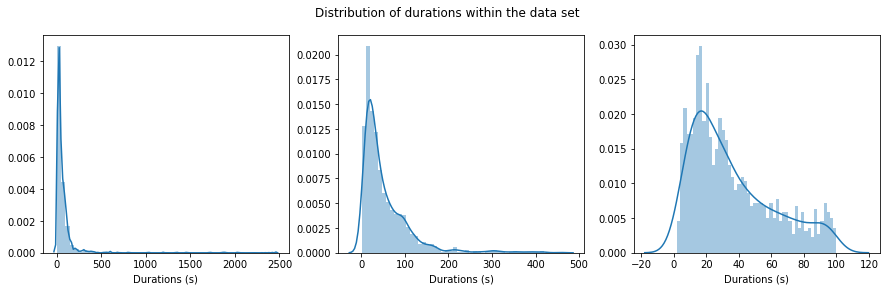

In [171]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.distplot(durations)
plt.subplot(1,3,2)
sns.distplot(durations[durations<500], bins=50)
plt.subplot(1,3,3)
sns.distplot(durations[durations<100], bins=50)
_ = [ax.set_xlabel('Durations (s)') for ax in fig.axes]
_ = plt.suptitle("Distribution of durations within the data set")

<p id="classify"></p>

# Classification of seizure vs. non-seizure EEG using a 2D convolutional neural network (2D)

## Data Preparation

The minimum duration of the training set is 16 seconds, the maximum duration is about 3000 seconds.

The duration of the seizure is minimum 2 seconds and maximum 2448 seconds.

I will "divide" the EEG spectrograms (0.5 second window, 128 frequencies, 19 channels) into 10 seconds chunks. This will yield a 20 x 128 x 19 matrix to feed into a 2D convolutional neural network for classification (inspired by [CNN Architectures for Large-Scale Audio Classification](https://arxiv.org/abs/1609.09430)). Essentially, the resulting trained model will be able to distinguish between seizure vs. non-seizure events given a 10-second EEG recording. Future application could be trained on shorter window for faster detection.

The "divide" part can be done in two ways: one deterministic and one by sampling. 

The deterministic way is the following: given a recording of duration D (e.g. 300 seconds of EEG recording), sample a window W (e.g. 10 seconds) from the beginning, either with overlapping of d (say 1 seconds, i.e. each successive window overlaps each other by 1 second), until reaching the end of the recording. Discard the last window less than W, or sample a window W backwards from the end. This will yield a total `floor(D / (W-d))` windows (plus 1 if choose to sample backwards).

The sampling way is the following: take total N samples from the entire dataset of total duration L. For each recording of duration D, take `round(D / L * N)` samples from the recording, uniformly across time.

We would need a lot of samples to train a proper neural network. The original MNIST dataset has 60,000 training images of 28 x 28, and 10,000 test images. The extended MNIST data (EMNIST) has 240,000 training images and 40,000 test images ([MNIST database](https://en.wikipedia.org/wiki/MNIST_database), a 4-fold augmentation. The training set has a total duration of 1186842 seconds, meaning a 10-second window with non-overlapping deterministic sampling would yield about 100,000 training samples. Since the seizure duration is 90464 seconds, there should be about 9,000 seizure samples. The test set has a total duration of 613232 seconds, and should yield about 60,000 test samples. Since the seizure duration is 60986, this should yield about 6,000 seizure test samples. The data can be futher augmented, of course, when adding overlapping windows.

The size of each sample should be kept small. The 20 x 128 x 19 matrix can be quite large (48640 points) in comparison to the MNIST dataset images (784 points). WE can discard the frequencies above 80 Hz, given that 1) most seizures occur at theta band frequencies (4-8 Hz, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2936439/) 2) the highest frequency in the brain is the gamma band (30-80 Hz, https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001045), and 3) the previous exploratory spectrogram plots revealed little to no activity at high frequencies above 60 Hz. The resulting matrix is now 20 x 80 x 19 (30400 points), about 37.5% reduction of data.

Other frameworks that could be considered include:

[LSTM Fully Convolutional Networks for Time Series Classification](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8141873)

In [2]:
# Make the data
def makeSpectrogram(eeg_data, channels, fs=256, window='hann', T=1, ts=0.5):
    """
    eeg_data
    channels: list of subset of channels 
    fs: samples per second.
    window: spectral window type. Default 'hann'
    T: window size (sec). Default 1 second
    ts: time resolution (sec). Deafult 0.5 second
    """
    
    warnings.filterwarnings("ignore")
    # Parse labels
    labels = [ll.replace("EEG ","").replace("-REF","").replace("-LE","") \
                for ll in eeg_data.header.labels]
    
    # channel by time_index 
    wdata = np.empty((len(channels), eeg_data.header.num_records * fs))
    # Make a matrix of the data
    for n, c in enumerate(channels):
        index = labels.index(c)
        if fs is not None and eeg_data.header.sample_rate[n] != fs:
            wdata[n, :] = signal.resample(eeg_data.data[index], eeg_data.header.num_records * fs)
        else:
            wdata[n, :] = eeg_data.data[index]
        
    # Apply the notch filter to filter out 60 Hz artifacts
    b, a = signal.iirnotch(60 / (fs/2), 30)
    wdata = signal.filtfilt(b, a, wdata, axis=1)
    
    # Make spectrogram
    frequencies, times, spectrogram = signal.spectrogram(wdata, fs, window=window,
                                                        nperseg=int(fs*T), noverlap=int(fs*(T-ts)))
    
    return frequencies, times, spectrogram # channels x frequencies x times

def tileSampleSpectrogram(frequencies, times, spectrogram, subset_time=None, subset_freq=None, 
                          duration=50, lag=0, sample_end=True, calculation_only=False):
    """
    Sample the spectrogram, given the returned frequencies, times, and 
    spectrogram (channels x frequencies x times), as well as
    * subset_time: use a subset of time window [start_sec, end_sec] to sample within
    * subset_freq: use a subset of frequencies [start_freq, end_freq]
    * duration: duration of each sample in seconds
    * lag: overlapping between each successive windows, in seconds
    * sample_end: whether or not to do backward 1 sample when the last sample leaks
    * calculation_only: return only the shape of the resulting matrix
    """    
    if subset_time is not None:
        a = np.where(times <= subset_time[0])[0][-1] # last point less than
        if not a: a = 0
        b = np.where(times >= subset_time[1])[0][0] # first point greater than
        if not b: b = None
        spectrogram = spectrogram[:, :, a:b]
        times = times[a:b]
    if subset_freq is not None:
        a = np.where(frequencies <= subset_freq[0])[0][-1] # last point less than
        if not a: a = 0
        b = np.where(frequencies >= subset_freq[1])[0][0]+1 # first point greater than
        if not b: b = None
        spectrogram = spectrogram[:, a:b, :]
        frequencies = frequencies[a:b]
        
    ts = times[1] - times[0] # sampling rate of the spectrogram
    
    # Calculate the shape of the resulting matrix after sampling
    shapes = list(spectrogram.shape)
    shapes[2] = int(duration / ts) # time points
    shapes.append(int(np.floor((times[-1]-times[0]+ts) / (duration - lag)) + sample_end))
    
    if calculation_only: # only calculate the shape of the resultign matrix
        return shapes
    
    wdata = np.empty(shapes)
    wtime = np.empty(shapes[2:])
    start_time = times[0]
    #print(wdata.shape)
    
    for i in range(shapes[-1]):
        end_time = start_time - ts + duration
        if end_time > times[-1]: break
        start_index = np.where(np.abs(times - start_time) < 1E-6)[0][0]
        end_index = np.where(np.abs(times - end_time) < 1E-6)[0][0]+1
        #print('start:', start_time, 'end:', end_time)
        #print('starti:', start_index, 'endi:', end_index)
        wdata[:, :, :, i] = spectrogram[:, :, start_index:end_index]
        wtime[:, i] = times[start_index:end_index]
        start_time = end_time - lag + ts
        
    if end_time > times[-1] and sample_end: # back sample 1
        end_time = times[-1]
        start_time = end_time - duration + ts
        start_index = np.where(np.abs(times - start_time) < 1E-6)[0][0]
        end_index = np.where(np.abs(times - end_time) < 1E-6)[0][0]+1
        #print('start:', start_time, 'end:', end_time)
        #print('starti:', start_index, 'endi:', end_index)
        wdata[:, :, :, -1] = spectrogram[:, :, start_index:end_index]
        wtime[:, -1] = times[start_index:end_index]

    return frequencies, wtime, wdata # channel x frequency x time x subsets    
    

In [284]:
eeg_data = EDF(P_train[13])    
frequencies, times, spectrogram = makeSpectrogram(eeg_data, channels=channels)
frequencies_sub, times_sub, spectrograms_sub = tileSampleSpectrogram(frequencies, times, spectrogram, 
                          subset_time=None, subset_freq=[0, 80], duration=10, lag=2, sample_end=True)
tileSampleSpectrogram(frequencies, times, spectrogram, 
                      subset_time=None, subset_freq=[0, 80], duration=10, lag=2, sample_end=True, 
                      calculation_only=True)

[19, 81, 20, 23]

The tiling sample method is going to separate the spectrograms into 3 categories: 1) tiles from non-seizure recordings ("non-seizure"); 2) tiles from seizure recordings, during seizure period (seizure type, e.g. "SPSZ"); and 3) tiles from seizure recordings, during non-seizure period ("background").

### Make the spectral data files

In [3]:
 # base directory of the project
# Where to save the project
def run_data_creation(P, df, duration=10, lag=2, sample_end=True, subset_freq=[0, 80], 
                      fs=256, window='hann', T=1, ts=0.5, 
                      basedir = '/Volumes/Storage/TUH_EEG',
                      savedir = '/Volumes/Storage/TUH_EEG',
                      channels = ['T4', 'O1', 'F8', 'FZ', 'P4', 'F4', 'F3', 'FP2', 'O2', 
                                  'T6', 'CZ', 'PZ', 'F7', 'C3', 'P3', 'T5', 'C4', 'T3', 'FP1']):
    fid = open(os.path.join(savedir, "progress.csv"), "w")
    fid.write(",".join(["Path", "Seizure Type", "\n"]))
    l = len(P)
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for i, p in enumerate(P):
        printProgressBar(i+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        # Subsetting the spectrogram
        eeg_data = EDF(p)
        frequencies, times, spectrogram = makeSpectrogram(eeg_data, channels=channels, fs=fs, window=window,
                                                         T=T, ts=ts)
        frequencies_sub, times_sub, spectrograms_sub = tileSampleSpectrogram(frequencies, times, spectrogram, 
                          subset_time=None, subset_freq=subset_freq, duration=duration, lag=lag, 
                          sample_end=sample_end)
        # Parse the tile
        q = p.replace(basedir, "./edf").replace(".edf", ".tse")
        df_subset = df.loc[df['Filename']==q, :].reset_index(drop=True)
        
        # Looping over all the tiles
        for t in range(spectrograms_sub.shape[3]): # for each tile
            savepath = q.split("/")
            savepath[2] = savepath[2]+ "_spectrogram" #("_nolabel_spectrogram" if df_subset.shape[0] == 0 else "_spectrogram")
            savepath = "/".join(savepath)
            savepath = savepath.replace("./edf", savedir)

            if df_subset.shape[0] == 0:
                seizure_type = "no label"
            else:
                for j in range(df_subset.shape[0]):
                    if np.isnan(df_subset.loc[j, 'Seizure Duration']):
                        seizure_type = "non-seizure"
                    else: # has seizure
                        if times_sub[:, t][0]<=df_subset.loc[j, 'Seizure End Time'] and \
                           times_sub[:, t][-1]>=df_subset.loc[j, 'Seizure Start Time']: 
                            # within seizure period: (StartA <= EndB) and (EndA >= StartB)
                            seizure_type = df_subset.loc[j, 'Seizure Type']
                            break
                        else: # outside of seizure period
                            seizure_type = 'background'

            current_savepath = savepath.replace(".tse", "_{:04d}.npz".format(t))
            current_folder = os.path.dirname(current_savepath)

            if not os.path.isdir(current_folder):
                os.makedirs(current_folder, exist_ok=True)

            np.savez_compressed(current_savepath, file_ref=q, 
                     frequencies=frequencies_sub, times=times_sub[:, t], 
                     spectrogram=spectrograms_sub[:, :, :, t].squeeze(), 
                     seizure_type=seizure_type)
            
            fid.write(",".join([current_savepath, seizure_type, "\n"]))
            
    fid.close()

In [378]:
%%time
run_data_creation(P_train, df_train)
print('Finished')

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Finished
CPU times: user 1h 33min 5s, sys: 12min 54s, total: 1h 46min
Wall time: 9h 8min 42s


In [381]:
%%time
run_data_creation(P_test, df_test)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 41min 57s, sys: 7min 2s, total: 48min 59s
Wall time: 2h 46min 36s


### Organize the csv file a little

In [419]:
import time
def organize_spectrogram_csv(df):
    df['Path_base'] = [p[:-9] for p in df['Path']]
    C, IC, counts = np.unique(df['Path_base'], return_inverse=True, return_counts=True)
    df['Num'] = IC
    df['Num Tiles'] = np.nan
    
    l = df.shape[0]
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50, mode="counts")
    for i in df.index:
        printProgressBar(i+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50, mode="counts")
        df.loc[i, 'Num Tiles'] = counts[df_spec_train.loc[i, 'Num']]
        time.sleep(0.001)

    df = df[['Num', 'Path', 'Seizure Type', 'Num Tiles']]
    return df


In [5]:
csv_file = os.path.join(basedir, '_DOCS', 'train_spectrogram_labels.csv')
df_spec_train = pd.read_csv(csv_file)
df_spec_train = organize_spectrogram_csv(df_spec_train)
df_spec_train.to_csv(csv_file, index=False)
df_spec_train.head()

In [420]:
csv_file = os.path.join(basedir, '_DOCS', 'dev_test_spectrogram_labels.csv')
df_spec_test = pd.read_csv(csv_file)
df_spec_test = organize_spectrogram_csv(df_spec_test)
df_spec_test.to_csv(csv_file, index=False)
df_spec_test.head()

endedess:  |██████████████████████████████████████████████████| 77239 / 77239 Complete


,Num,Path,Seizure Type,Num Tiles
0,0,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,3.0
1,0,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,3.0
2,0,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,3.0
3,1,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,background,34.0
4,1,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,TCSZ,34.0


### Explore the distribution of number of tiles in each type of recordings

In [5]:
basedir = '/Volumes/Storage/TUH_EEG/'
csv_file = os.path.join(basedir, '_DOCS', 'train_spectrogram_labels.csv')
df_spec_train = pd.read_csv(csv_file)

df_spec_train.loc[np.logical_and(df_spec_train['Seizure Type'] != 'background',
                 df_spec_train['Seizure Type'] != "non-seizure"), "Seizure Type"] = "seizure"

gp = df_spec_train.groupby(by=['Num', 'Seizure Type'], as_index=False, sort=False)
Summary = gp.count()
Summary.tail()

,Num,Seizure Type,Path,Num Tiles
2378,1734,non-seizure,7,7
2379,1732,non-seizure,30,30
2380,1733,non-seizure,47,47
2381,1737,non-seizure,47,47
2382,1736,non-seizure,7,7


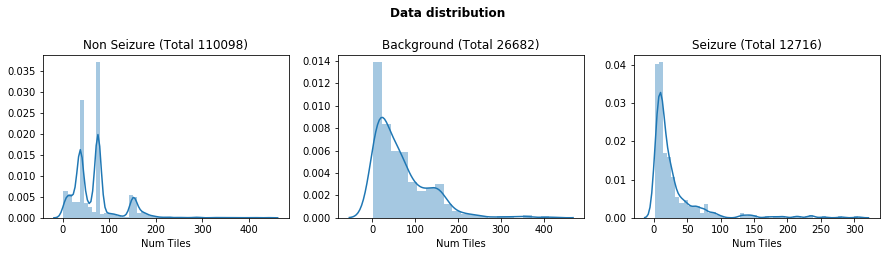

In [448]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
F = Summary.loc[Summary['Seizure Type']=='non-seizure', 'Num Tiles']
sns.distplot(F)
_ = plt.title('Non Seizure (Total {:d})'.format(F.sum()))
plt.subplot(1, 3, 2)
F = Summary.loc[Summary['Seizure Type']=='background', 'Num Tiles']
sns.distplot(F)
_ = plt.title('Background (Total {:d})'.format(F.sum()))
plt.subplot(1, 3, 3)
F = Summary.loc[Summary['Seizure Type']=='seizure', 'Num Tiles']
sns.distplot(F)
_ = plt.title('Seizure (Total {:d})'.format(F.sum()))
_ = plt.suptitle("Data distribution", y=1.1, fontweight='bold')

In [ ]:
Summary_non_seizure = Summary.loc[np.logical_and.reduce([Summary['Seizure Type'] == 'non-seizure', 
                           Summary['Num Tiles']>25, Summary['Num Tiles']<40]), :]
print("non-seizure:", Summary_non_seizure['Num Tiles'].sum())
Summary_background = Summary.loc[np.logical_and.reduce([Summary['Seizure Type'] == 'background', 
                           Summary['Num Tiles']>25, Summary['Num Tiles']<125]), :]
print("background:", Summary_background['Num Tiles'].sum())

**Conclusion**: Apply a filter such that num tiles between 25 and 40 is used for non-seizure (14769 samples). For the dataset with seizures, randomly take ~50% of the background periods. This shoudl help mitigate the unbalanced data problem.

### Make the balanced subset of training data

In [13]:
csv_file = os.path.join(basedir, '_DOCS', 'train_spectrogram_labels.csv')
df_spec_train = pd.read_csv(csv_file)
df_non_seizure = df_spec_train.loc[np.logical_and(df_spec_train['Seizure Type']=='non-seizure',
                                    [df_spec_train.loc[i, 'Num'] in Summary_non_seizure['Num'].values \
                                     for i in df_spec_train.index]), :]

df_non_seizure.shape

(14769, 4)

In [9]:
df_background = df_spec_train.loc[df_spec_train['Seizure Type']=='background']
np.random.seed(42)
for n in df_background['Num'].unique():
    indices = df_background.loc[df_background['Num']==n, :].index
    if len(indices) < 2:
        continue # keep evreything
    selected_indices = np.random.choice(indices, size=(len(indices)//2), replace=False)
    df_background = df_background.drop(index=selected_indices)

df_background.shape
    

(13446, 4)

In [14]:
df_seizure = df_spec_train.loc[np.logical_and(df_spec_train['Seizure Type']!='background', \
                                          df_spec_train['Seizure Type']!= 'non-seizure'), :]
df_seizure.shape

(12716, 4)

In [17]:
df_final = df_non_seizure.append(df_background).append(df_seizure)
df_final = df_final.sort_values(by='Path')
df_final['Class'] = 0
df_final.loc[df_final['Seizure Type']=='non-seizure', 'Class'] = 0
df_final.loc[df_final['Seizure Type']=='background', 'Class'] = 1
df_final.loc[np.logical_and(df_final['Seizure Type']!='non-seizure', 
                        df_final['Seizure Type']!='background'), 'Class'] = 2
#df_final.to_csv(os.path.join(basedir, '_DOCS', 'train_spectrogram_balanced.csv'), index=False)
df_final.tail()

,Num,Path,Seizure Type,Num Tiles,Class
133786,1982,/Volumes/Storage/TUH_EEG/train_spectrogram/03_...,non-seizure,38.0,0
133787,1982,/Volumes/Storage/TUH_EEG/train_spectrogram/03_...,non-seizure,38.0,0
133788,1982,/Volumes/Storage/TUH_EEG/train_spectrogram/03_...,non-seizure,38.0,0
133789,1982,/Volumes/Storage/TUH_EEG/train_spectrogram/03_...,non-seizure,38.0,0
133790,1982,/Volumes/Storage/TUH_EEG/train_spectrogram/03_...,non-seizure,38.0,0


### Make the balanced subset of test data

In [9]:
basedir = '/Volumes/Storage/TUH_EEG/'
df_spec_test = pd.read_csv(os.path.join(basedir, '_DOCS', 'dev_test_spectrogram_labels.csv'))
gp = df_spec_test.groupby(by=['Num', 'Seizure Type'], as_index=False, sort=False)
Summary_non_seizure = gp.mean()
Summary_non_seizure = Summary_non_seizure.loc[np.logical_and.reduce([
    Summary_non_seizure['Seizure Type']=='non-seizure', 
    Summary_non_seizure['Num Tiles'] > 25, 
    Summary_non_seizure['Num Tiles'] < 40],
), :]

df_non_seizure = df_spec_test.loc[np.logical_and(df_spec_test['Seizure Type']=='non-seizure',
                                    [df_spec_test.loc[i, 'Num'] in Summary_non_seizure['Num'].values \
                                     for i in df_spec_test.index]), :]
# Randomly take a subset of samples from the number filtered data
num_rows = df_non_seizure.shape[0]
np.random.seed(42)
for n in df_non_seizure['Num'].unique():
    indices = df_non_seizure.loc[df_non_seizure['Num']==n, :].index
    if len(indices) < 2:
        continue # keep evreything
    selected_indices = np.random.choice(indices, size=(round(len(indices)*(1-8574/num_rows))), replace=False)
    df_non_seizure = df_non_seizure.drop(index=selected_indices)

df_non_seizure.shape

(8586, 4)

In [10]:
df_background = df_spec_test.loc[df_spec_test['Seizure Type']=='background', :]
np.random.seed(42)
for n in df_background['Num'].unique():
    indices = df_background.loc[df_background['Num']==n, :].index
    if len(indices) < 2:
        continue # keep evreything
    selected_indices = np.random.choice(indices, size=(round(len(indices)*(1-8574/21045))), replace=False)
    df_background = df_background.drop(index=selected_indices)

df_background.shape


(8577, 4)

In [11]:
df_seizure = df_spec_test.loc[np.logical_and.reduce([df_spec_test['Seizure Type']!='background',
                                                    df_spec_test['Seizure Type']!='non-seizure',
                                                    df_spec_test['Seizure Type']!='no label']), :]
df_seizure.shape

(8408, 4)

In [12]:
df_final = df_non_seizure.append(df_background).append(df_seizure)
df_final = df_final.sort_values(by='Path')
df_final['Class'] = 0
df_final.loc[df_final['Seizure Type']=='non-seizure', 'Class'] = 0
df_final.loc[df_final['Seizure Type']=='background', 'Class'] = 1
df_final.loc[np.logical_and(df_final['Seizure Type']!='non-seizure', 
                        df_final['Seizure Type']!='background'), 'Class'] = 2
df_final.to_csv(os.path.join(basedir, '_DOCS', 'dev_test_spectrogram_balanced.csv'), index=False)
df_final.tail()

,Num,Path,Seizure Type,Num Tiles,Class
74778,1009,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,35.0,0
74779,1009,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,35.0,0
74781,1009,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,35.0,0
74782,1009,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,35.0,0
74783,1009,/Volumes/Storage/TUH_EEG/dev_test_spectrogram/...,non-seizure,35.0,0


### Three classes of spectral images to classify

In [75]:
channel_names = ['T4', 'O1', 'F8', 'FZ', 'P4', 'F4', 'F3', 'FP2', 'O2', 'T6', 'CZ', 'PZ', 'F7', 'C3', 'P3', 
            'T5', 'C4', 'T3', 'FP1']
def inspect_spectrogram(spectrogram_path, channels=[1, 6, 7], plot_shape=(1, 3), canvas_size=(15, 4), 
                        y=1.05, wspace=0.25, hspace=0.25, titlestr=""):
    X = np.load(spectrogram_path)
    times, frequencies, spectrogram = X['times'], X['frequencies'], X['spectrogram']
    for i in range(len(channels)):
        plt.subplot(*plot_shape, i+1)
        plt.pcolormesh(times, frequencies, spectrogram[channels[i], :, :], cmap='jet')
        plt.xlabel('Time [Sec]')
        _ = plt.ylabel('Frequency [Hz]')
        _ = plt.title('Channel {}'.format(channel_names[channels[i]]))
    _ = plt.suptitle(titlestr,fontsize=16, fontweight='bold', y=y)
    plt.gcf().set_size_inches(canvas_size)
    plt.gcf().subplots_adjust(wspace=wspace, hspace=hspace)

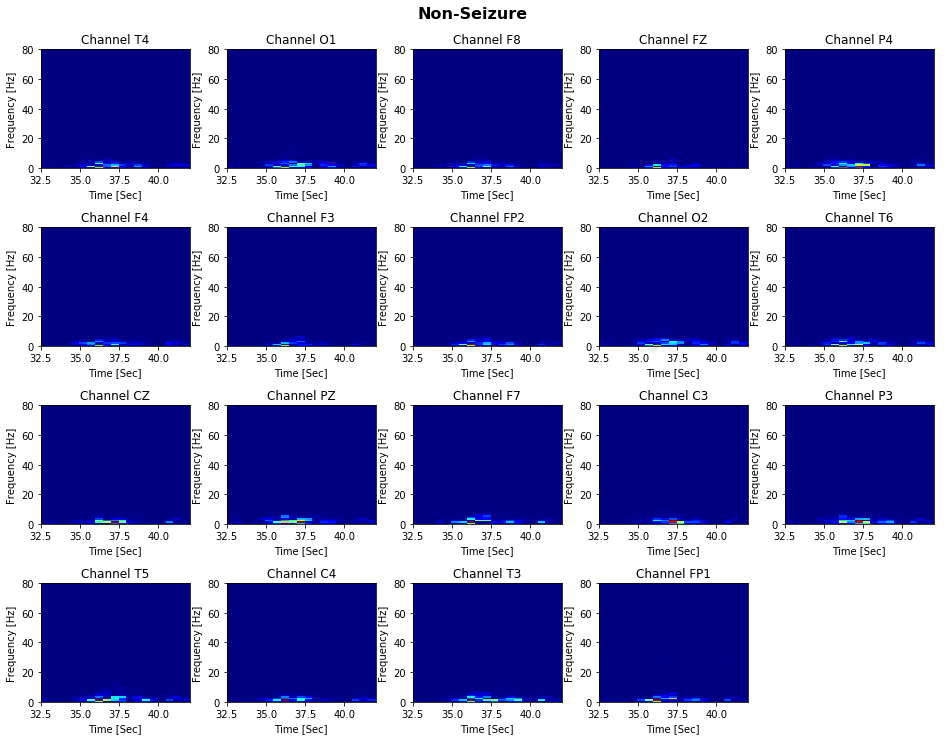

In [88]:
spectrogram_path = \
'./TUH_EEG/train_spectrogram/01_tcp_ar/028/00002868/s003_2013_08_07/00002868_s003_t000_0004.npz'
inspect_spectrogram(spectrogram_path, channels=np.arange(0, 19), plot_shape=(4, 5), canvas_size=(16, 12), y=0.93,
                   titlestr="Non-Seizure", wspace=0.25, hspace=0.5)

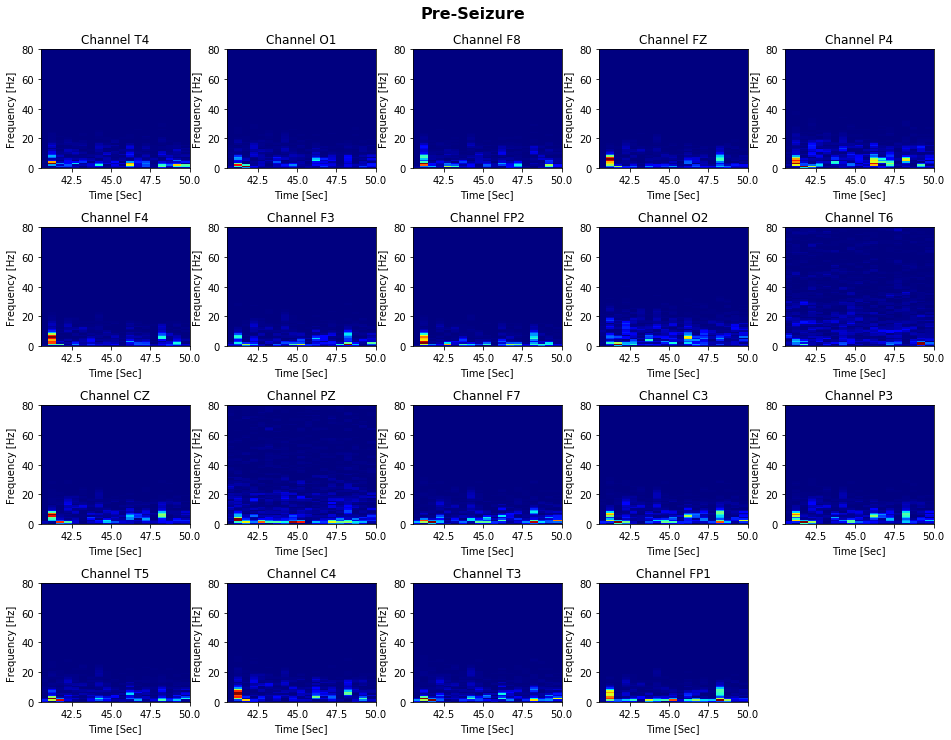

In [131]:
spectrogram_path = \
'./TUH_EEG/train_spectrogram/01_tcp_ar/028/00002806/s001_2004_12_23/00002806_s001_t006_0005.npz'
inspect_spectrogram(spectrogram_path, channels=np.arange(0, 19), plot_shape=(4, 5), canvas_size=(16, 12), y=0.93,
                   titlestr="Pre-Seizure", wspace=0.25, hspace=0.5)

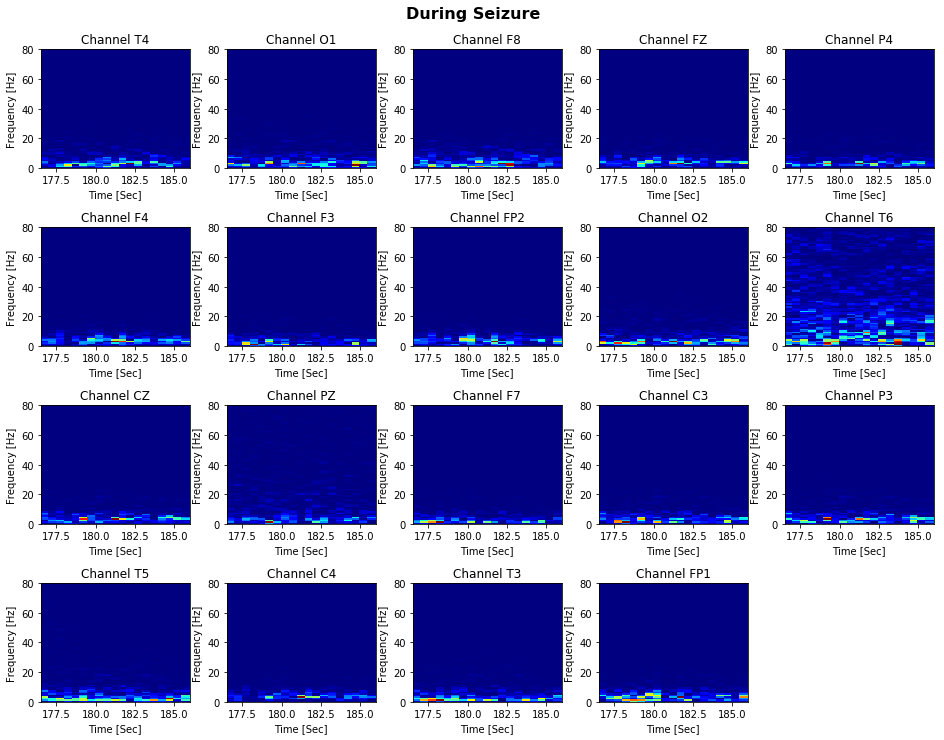

In [106]:
spectrogram_path = \
'./TUH_EEG/train_spectrogram/01_tcp_ar/028/00002806/s001_2004_12_23/00002806_s001_t006_0022.npz'
inspect_spectrogram(spectrogram_path, channels=np.arange(0, 19), plot_shape=(4, 5), canvas_size=(16, 12), y=0.93,
                   titlestr="During Seizure", wspace=0.25, hspace=0.5)

**Conclusion**: The non-seizure EEG recordings typically has little activiites in the high frequencies. In contrast, both the pre-seizure and during-seizure recordings seem to have widespread higher frequencies activities. In the above example, during seizure period, activities of Channel T6 was heightened in comparison to that of pre-seizure period, while activities of several other channels were suppressed. In general, the task to distinguish between pre-seizure and during-seizure spectrograms can be especially difficult to human, given the sheer amount of data. However, the difference in characteristics could be detected by a deep learning neural network.

## 2D Convolutional Neural Network with Keras

Recall the data is a channel x freqs x times (19 x 81 x 20) matrix. 

In [2]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import time

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Splitting the data

In [3]:
basedir = './'
df_train = pd.read_csv(os.path.join(basedir, '_DOCS', 'train_spectrogram_balanced.csv'))
df_test = pd.read_csv(os.path.join(basedir, '_DOCS', 'dev_test_spectrogram_balanced.csv'))
df = df_train.append(df_test).reset_index(drop=True)
df = df.sample(frac=1, random_state=1) # shuffle

# Split df_test further into df_test and df_val
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Class'])
df_test, df_val   = train_test_split(df_test, test_size=0.5, random_state=43, stratify=df_test['Class'])

In [4]:
def print_split(df, df_train, df_test, df_val):
    gp = df.groupby(by=['Class'], sort=False, as_index=False)
    Summary_df = gp.count()['Path']
    gp = df_train.groupby(by=['Class'], sort=False, as_index=False)
    Summary_df_train = gp.count()['Path']
    gp = df_test.groupby(by=['Class'], sort=False, as_index=False)
    Summary_df_test = gp.count()['Path']
    gp = df_val.groupby(by=['Class'], sort=False, as_index=False)
    Summary_df_val = gp.count()['Path']
    Summary = pd.DataFrame({'All': Summary_df, 'Train': Summary_df_train,
                           'Test': Summary_df_test, 'Val': Summary_df_val})
    
    return Summary
print_split(df, df_train, df_test, df_val)

,All,Train,Test,Val
0,22023,15416,3303,3304
1,21124,14787,3503,3504
2,23355,16348,3169,3168


### Data generator

Since our dataset is so big, it won't fit in the memory. We can implement a data generator class to load each batch of data.

In [5]:
# Generating data
batch_size = 50
num_classes = 3
epochs = 100

class DataGenerator(keras.utils.Sequence):
    """Generate data for Keras"""
    def __init__(self, df, batch_size=50, num_classes=3, shuffle=False, dataset=None, dims=[19, 81, 20]):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dims = dims
        self.shuffle = shuffle
        self.df = df
        self.dataset = dataset
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        num_batches = self.df.shape[0] // self.batch_size + (self.df.shape[0] % self.batch_size > 0)
        return num_batches
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        start_index = index * self.batch_size
        end_index = (index+1) * self.batch_size
        if end_index > self.df.shape[0]:
            end_index = None
        rows = self.df.index[start_index:end_index]
        
        X, y = self.__data_generation(rows)

        return X, y
    
    def on_epoch_end(self):
        """Update indexes after each epoch"""
        start_time = time.clock()
        if self.shuffle:
            self.df = self.df.sample(frac=1, replace=False).reset_index(drop=True)
            #print('\nIs shuffled\n')
       # print('\ncall on_epoch_end: ', time.clock()-start_time, "from ", self.dataset, "\n")

            
    def __data_generation(self, rows):
        nrows = len(rows)
        # Initialize
        dims = [nrows] + list(self.dims)
        X = np.empty(dims)
        y = np.empty(nrows)
        #start_time = time.clock()
        for n, r in enumerate(rows):
            #print(self.df.loc[r, 'Num'])
            X[n, :, :, :] = np.load(os.path.join(self.df.loc[r, 'Path']))['spectrogram']
            y[n] = int(self.df.loc[r, 'Class'])
        # normalization by each file by each channel in the batch
        Xmin = X.min(axis=2, keepdims=True).min(axis=3, keepdims=True)
        Xmax = X.max(axis=2, keepdims=True).max(axis=3, keepdims=True)
        Scale = Xmax - Xmin
        Scale[Scale<1] = 1
        X = (X - Xmin) / Scale
        y = keras.utils.to_categorical(y, self.num_classes)
        #print('\ndata loading time: ', time.clock()-start_time, "from ", self.dataset, "\n")
        return X, y
        
            
train_generator = DataGenerator(df_train.reset_index(drop=True), batch_size=50, num_classes=3, shuffle=True, dataset='train')
test_generator = DataGenerator(df_test.reset_index(drop=True), batch_size=50, num_classes=3, dataset='test')
val_generator = DataGenerator(df_val.reset_index(drop=True), batch_size=50, num_classes=3, dataset='val')

Alternatively, one may write a generator function as below.

In [48]:
def data_generator(df, batch_size=50, num_classes=3, shuffle=True, dataset=None):
    while True:
        if shuffle:
            df = df.sample(frac=1)
        df = df.reset_index(drop=True)
        num_batches = df.shape[0] // batch_size + (df.shape[0] % batch_size > 0)
        for index in range(num_batches):
            start_index = index * batch_size
            end_index = (index+1) * batch_size
            if end_index > df.shape[0]:
                end_index = None
            rows = df.index[start_index:end_index]
            nrows = len(rows)
            # Initialize
            X = [[]] * nrows
            y = [[]] * nrows

            for n, r in enumerate(rows):
                X[n] = np.load(os.path.join(df.loc[r, 'Path']))['spectrogram']
                y[n] = int(df.loc[r, 'Class'])
            X = np.array(X)
            y = keras.utils.to_categorical(y, num_classes)
            yield X, y
            
            

### Model specification

Starting with a very simple CNN model.

In [6]:
tf.reset_default_graph()
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=[19, 81, 20],
          data_format="channels_first", activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal', 
                 ))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', 
                kernel_initializer='he_normal'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

# Let's train the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 81, 20)        2752      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 81, 32)        5792      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 40, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 40, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 40, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 40, 64)         36928     
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 20, 64)         0         
__________

### Train

In [7]:
#checkfilepath = os.path.join(basedir, "results/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5")
#checkpoint = ModelCheckpoint(checkfilepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

history = model.fit_generator(train_generator, 
                              epochs=epochs,
                              validation_data=val_generator, #callbacks = [checkpoint],
                              verbose=1)

Epoch 1/100
932/932 [==============================] - 561s 602ms/step - loss: 1.2064 - acc: 0.4184 - val_loss: 1.0028 - val_acc: 0.5010
Epoch 2/100
932/932 [==============================] - 589s 632ms/step - loss: 1.0713 - acc: 0.4571 - val_loss: 0.9651 - val_acc: 0.5305
Epoch 3/100
932/932 [==============================] - 597s 640ms/step - loss: 0.9958 - acc: 0.5060 - val_loss: 0.9019 - val_acc: 0.5670
Epoch 4/100
932/932 [==============================] - 654s 702ms/step - loss: 0.9219 - acc: 0.5519 - val_loss: 0.8618 - val_acc: 0.5886
Epoch 5/100
932/932 [==============================] - 712s 764ms/step - loss: 0.8671 - acc: 0.5899 - val_loss: 0.8041 - val_acc: 0.6279
Epoch 6/100
932/932 [==============================] - 627s 672ms/step - loss: 0.8342 - acc: 0.6119 - val_loss: 0.7814 - val_acc: 0.6445
Epoch 7/100
932/932 [==============================] - 591s 634ms/step - loss: 0.8037 - acc: 0.6314 - val_loss: 0.7517 - val_acc: 0.6598
Epoch 8/100
932/932 [====================

TypeError: evaluate_generator() got an unexpected keyword argument 'verbose'

In [9]:
scores = model.evaluate_generator(test_generator)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.6515918852840749
Test accuracy: 0.8253634031255144


In [10]:
# Serialize the model to json
model_json = model.to_json()
with open(os.path.join(basedir, "results/EEG_TUH_spectrogram_CNN_model.json"), "w") as json_file:
    json_file.write(model_json)
#Serialize weights to HDF5
model.save_weights(os.path.join(basedir, "results/EEG_TUH_spectrogram_CNN_weights.h5"))
# save history
with open(os.path.join(basedir, 'results/EEG_TUH_spectrogram_history.json'), 'w') as f:
    json.dump(history.history, f)

### Confusion matrix

200/200 [==============================] - 49s 247ms/step


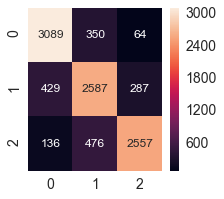

In [16]:
# Calulate the prediction
y_test = df_test['Class']
Y_pred = model.predict_generator(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1) # convert one-hot into indices
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize=(3,3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={'size':12}) # font size
plt.show()

### Traning history

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

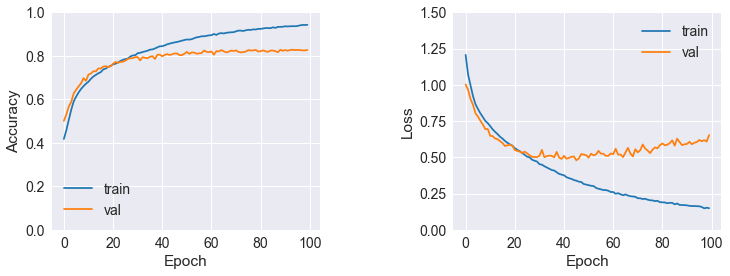

In [31]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['acc'], label='train', color='#1f77b4')
axs[0].plot(history.history['val_acc'], label='val', color='#ff7f0e')
axs[0].legend()
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])
axs[1].plot(history.history['loss'], label='train', color='#1f77b4')
axs[1].plot(history.history['val_loss'], label='val', color='#ff7f0e')
axs[1].legend()
axs[1].set_ylim([0, 1.5])
axs[1].set_ylabel('Loss')
fig.set_size_inches(12, 4)
[ax.set_xlabel('Epoch') for ax in axs]
fig.subplots_adjust(wspace=0.5)
history.history.keys()

**Conclusion**: a simple CNN trained on the 10-second-long spectrogram (< 80 Hz) of 19 channel EEG data can distinguish between non-seizure, background (before or in between seizure events), and during seizure recordings, with accuracy about 83%. This is suggesting that given a piece of EEG recording of multiple channels, deep learning can help detect potential seizure events. The ability of the CNN to recognize background recordings before or in-between seizure events would also help healthcare practitioner predict the subsequent onset of seizure. Future effort could train on shorter durations of the EEG recording snippets, in addition to improving the accuracy of classification.